In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench import (
    ema_logging,
    MultiprocessingEvaluator,
    Scenario,
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.analysis import parcoords
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress,
                                                     to_problem,
                                                     )

In [2]:
ema_logging.log_to_stderr(level=ema_logging.INFO)

<Logger EMA (DEBUG)>

In [10]:
dike_model, planning_steps = get_model_for_problem_formulation(3)

In [11]:
epsilon = [0.1]* len(dike_model.outcomes)

In [12]:
for outcome in dike_model.outcomes:
    print(outcome.name)

A.1 Total Costs
A.1_Expected Number of Deaths
A.2 Total Costs
A.2_Expected Number of Deaths
A.3 Total Costs
A.3_Expected Number of Deaths
A.4 Total Costs
A.4_Expected Number of Deaths
A.5 Total Costs
A.5_Expected Number of Deaths
RfR Total Costs
Expected Evacuation Costs


In [13]:
reference_scenario = Scenario(
    'reference',
    **{
        # Parameters (uncertainties)
        'discount rate 0': 1.5,
        'discount rate 1': 1.5,
        'discount rate 2': 1.5,
        'A.0_ID flood wave shape': 30,
        'A.1_Bmax': 190.0,
        'A.1_pfail': 0.6720691719092429,
        'A.1_Brate': 1.0,
        'A.2_Bmax': 245.05131609737873,
        'A.2_pfail': 0.5,
        'A.2_Brate': 1.0,
        'A.3_Bmax': 190.0,
        'A.3_pfail': 0.5,
        'A.3_Brate': 1.0,
        'A.4_Bmax': 190.0,
        'A.4_pfail': 0.5,
        'A.4_Brate': 1.0,
        'A.5_Bmax': 190.0,
        'A.5_pfail': 0.5,
        'A.5_Brate': 1.0,
    }
)

In [14]:
logger = ArchiveLogger(
            r"output",
            decision_varnames=[l.name for l in dike_model.levers],
            outcome_varnames=[o.name for o in dike_model.outcomes],
            base_filename="test_archive.tar.gz",
            )

convergence_metrics = [logger, EpsilonProgress()]

In [15]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=50,
                                              searchover="levers",
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference= reference_scenario,
                                              )


[MainProcess/INFO] pool started with 16 workers
100it [00:13,  7.58it/s]                                                       
[MainProcess/INFO] optimization completed, found 82 solutions
[MainProcess/INFO] terminating pool


In [16]:
results.columns

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'],
      dtype='object')

In [17]:
outcomes = results.loc[:, ['A.4 Total Costs',
                           'A.4_Expected Number of Deaths',
                           'A.5 Total Costs',
                           'A.5_Expected Number of Deaths']]

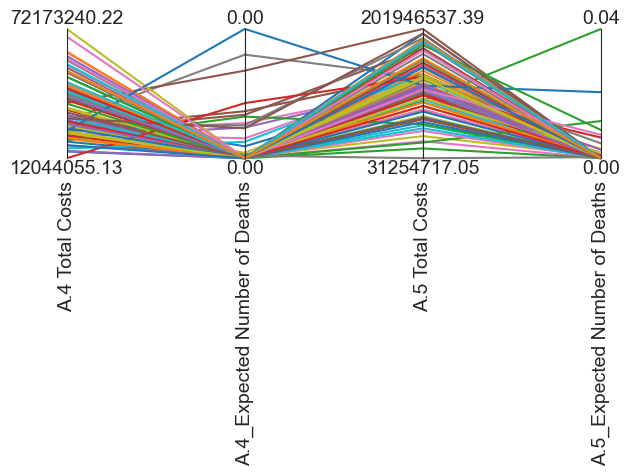

In [19]:
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

plt.show()

In [10]:
def calculate_metrics(archives, reference_set):
    problem = to_problem(dike_model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics

In [11]:
def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel(r'$\epsilon$ progress')

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

In [12]:
archives = ArchiveLogger.load_archives(f"./output/test_archive.tar.gz")
reference_set = archives[max(archives.keys())] # this is the final archive


problem = to_problem(dike_model, searchover="levers", reference=reference_scenario)
problem.parameter_names

#hv = HypervolumeMetric(reference_set, problem)
#gd = GenerationalDistanceMetric(reference_set, problem, d=1)
#ei = EpsilonIndicatorMetric(reference_set, problem)
#ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
#sm = SpacingMetric(problem)

['0_RfR 0',
 '0_RfR 1',
 '0_RfR 2',
 '1_RfR 0',
 '1_RfR 1',
 '1_RfR 2',
 '2_RfR 0',
 '2_RfR 1',
 '2_RfR 2',
 '3_RfR 0',
 '3_RfR 1',
 '3_RfR 2',
 '4_RfR 0',
 '4_RfR 1',
 '4_RfR 2',
 'EWS_DaysToThreat',
 'A.1_DikeIncrease 0',
 'A.1_DikeIncrease 1',
 'A.1_DikeIncrease 2',
 'A.2_DikeIncrease 0',
 'A.2_DikeIncrease 1',
 'A.2_DikeIncrease 2',
 'A.3_DikeIncrease 0',
 'A.3_DikeIncrease 1',
 'A.3_DikeIncrease 2',
 'A.4_DikeIncrease 0',
 'A.4_DikeIncrease 1',
 'A.4_DikeIncrease 2',
 'A.5_DikeIncrease 0',
 'A.5_DikeIncrease 1',
 'A.5_DikeIncrease 2']

In [13]:
archives[max(archives.keys())].columns

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'Expected Annual Damage', 'Dike Investment Costs',
       'RfR Investment Costs', 'Evacuation Costs',
       'Expected Number of Deaths'],
      dtype='object')

In [14]:
archives = ArchiveLogger.load_archives(f"./output/test_archive.tar.gz")
reference_set = archives[max(archives.keys())] # this is the final archive

metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

EMAError: Parameter names ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive

In [32]:
reference_set = archives[max(archives.keys())]
archive = reference_set

In [33]:
archive.itertuples()

In [37]:
for row in archive.itertuples():
    print(dir(row))


['EWS_DaysToThreat', 'Index', '_1', '_10', '_11', '_12', '_13', '_14', '_15', '_17', '_18', '_19', '_2', '_20', '_21', '_22', '_23', '_24', '_25', '_26', '_27', '_28', '_29', '_3', '_30', '_31', '_32', '_33', '_34', '_35', '_36', '_4', '_5', '_6', '_7', '_8', '_9', '__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'index']
['EWS_DaysToThreat', 'Index', '_1', '_10', '_11', '_12', '_13', '_14', '_15', '_17', '_18', '_19', '_2', '_20', '_21', '_22', '_23', '_24', '_25', '_26', '_27', '_

In [39]:
type(archive)

pandas.core.frame.DataFrame

In [40]:
archive.columns

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'Expected Annual Damage', 'Dike Investment Costs',
       'RfR Investment Costs', 'Evacuation Costs',
       'Expected Number of Deaths'],
      dtype='object')

In [43]:
dike_model.levers[0]

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)